## 引入工具

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, Markdown, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 95))

import sys, os, io, time, random, math
import json, base64, requests
import os.path as osp
import threading

def _IMPORT_(x):
    try:
        segs = x.split(' ')
        g = globals()
        if 'github.com' in segs[1]:
            uri = segs[1].replace('github.com', 'raw.githubusercontent.com')
            mod = uri.split('/')
            uri = 'https://' + '/'.join(mod[:-1]) + '/main/' + mod[-1] + '.py'
            x = requests.get(uri).text
        elif 'gitee.com' in segs[1]:
            mod = segs[1].split('/')
            uri = 'https://' + '/'.join(mod[:-1]) + '/raw/main/' + mod[-1] + '.py'
            x = requests.get(uri).text
        elif segs[1][0] == '/':
            with open(segs[1] + '.py') as fr:
                x = fr.read()
        exec(x, g)
    except Exception as err:
        print(err)

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()

def img2b64(x):
    if isinstance(x, bytes):
        return base64.b64encode(x).decode()
    elif isinstance(x, str):
        with open(x, 'rb') as fr:
            return base64.b64encode(fr.read()).decode()
    raise
  

CPython 3.6.9
IPython 7.16.1

numpy 1.19.5
sklearn 0.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.3
PIL 8.3.1
matplotlib 3.3.4
CPython 3.6.9
IPython 7.16.1

torch 1.8.1+cu101
torchvision 0.9.1+cu101
torchaudio not installed


In [129]:
###
### Common ###
###

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')



###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')
_IMPORT_('import ipywidgets as widgets')
_IMPORT_('from ipywidgets import interact, interactive, fixed, interact_manual')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [130]:
_IMPORT_('import /data/nb_easy/easy_widget')

## 解析配置

In [153]:
from utils import EVENTS

RACEURL = 'http://116.85.5.40:9119'
MSGKEY = 'nb.zmq.repnet_tf.eta'

with open('schema.json', 'r') as fr:
    schema_string = fr.read()
    schema_string = schema_string.replace('zmq.repnet_tf.test', MSGKEY)
    schema_string = schema_string.replace('http://host:port', RACEURL)
    schema = json.loads(schema_string)
easy = nbeasy_schema_parse(schema, events=EVENTS, debug=True);

Box(children=(Box(children=(VBox(children=(Tab(children=(VBox(children=(HBox(children=(Text(value='zmq.repnet_…

In [11]:
a = np.random.randn(3,4)
a

array([[ 0.80557867, -0.00887303,  1.76799741,  0.73778978],
       [ 0.0053556 ,  0.45138405, -0.22516373,  0.66078217],
       [-0.12153746,  0.76018512, -1.09915674,  1.08703538]])

In [13]:
np.round(a, 3)

array([[ 0.806, -0.009,  1.768,  0.738],
       [ 0.005,  0.451, -0.225,  0.661],
       [-0.122,  0.76 , -1.099,  1.087]])

In [17]:
import cv2


def cal_rect_points(w, h, box):
    if box[0] < 1.0 and box[1] < 1.0 and box[2] <= 1.0 and box[3] <= 1.0:
        x1, y1 = int(w * box[0]), int(h * box[1])
        x2, y2 = int(w * box[2]), int(h * box[3])
    else:
        x1, y1 = box[0], box[1]
        x2, y2 = box[2], box[3]
    return x1, y1, x2, y2



In [143]:
cap = cv2.VideoCapture('/data/20220118093227.mp4')
focus_box = [0.51, 0.45, 0.58, 0.65]
# cap = cv2.VideoCapture('/data/20220117080607.mp4')
# focus_box = [0.47,0.35,0.57,0.5]

rm_still = True
rot = False
width = 224
height = 224
focus_box_repnum = 3
area_rate_thres = 0.03

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
focus_x1, focus_y1, focus_x2, focus_y2 = cal_rect_points(w, h, focus_box)
w = focus_x2 - focus_x1
h = focus_y2 - focus_y1

pre_frame = None
area_thres = math.ceil(area_rate_thres * w * h)
print(f'rm_still: {area_thres} = ceil({area_rate_thres} * {w} * {h})')
frames = []
still_frames = []
test1, test2 = None, None
frame_tmp = None
if cap.isOpened():
    frame_idx = 0
    while True:
        success, frame_bgr = cap.read()
        if not success:
            break
        keep_flag = False
        if focus_box is not None:
            frame_bgr = frame_bgr[focus_y1:focus_y2, focus_x1:focus_x2, :]
            
        # frame_hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
        # frame_hsv[:, :, 2] *= 0.1 
        # print(frame_hsv[:, :, 2])
        # frame_tmp = cv2.cvtColor(frame_hsv, cv2.COLOR_HSV2BGR)
        frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
        # img_hsv = img_hsv[:, :, ]
        # frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_HSV2GRAY)
        if pre_frame is not None:
            frame_tmp = cv2.absdiff(frame_gray, pre_frame)
            frame_tmp = cv2.threshold(frame_tmp, 20, 255, cv2.THRESH_BINARY)[1]
            frame_tmp = cv2.dilate(frame_tmp, None, iterations=2)
            contours, _ = cv2.findContours(frame_tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            if len(contours) > 0:
                for contour in contours:
                    if cv2.contourArea(contour) > area_thres:
                        keep_flag = True
                        test1 = frame_gray
                        test2 = pre_frame
                        raise
                        break
        pre_frame = frame_gray

        if focus_box is not None:
            if focus_box_repnum > 1:
                frame_bgr = np.hstack([frame_bgr] * focus_box_repnum)
                frame_bgr = np.vstack([frame_bgr] * focus_box_repnum)
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        frame_rgb = cv2.resize(frame_rgb, (width, height))
        if rot:
            # frame_rgb = cv2.rotate(frame_rgb, rot)
            M = cv2.getRotationMatrix2D(center=(int(width / 2), int(height / 2)), angle=rot, scale=1.0)
            frame_rgb = cv2.warpAffine(frame_rgb, M, (width, height))
        if frame_idx and rm_still and not keep_flag:
            still_frames.append((frame_idx, frame_rgb))
        else:
            frames.append(frame_rgb)
        frame_idx += 1

        del frame_bgr


rm_still: 95 = ceil(0.03 * 45 * 70)


RuntimeError: No active exception to reraise

In [149]:
tmp.dtype

dtype('float64')

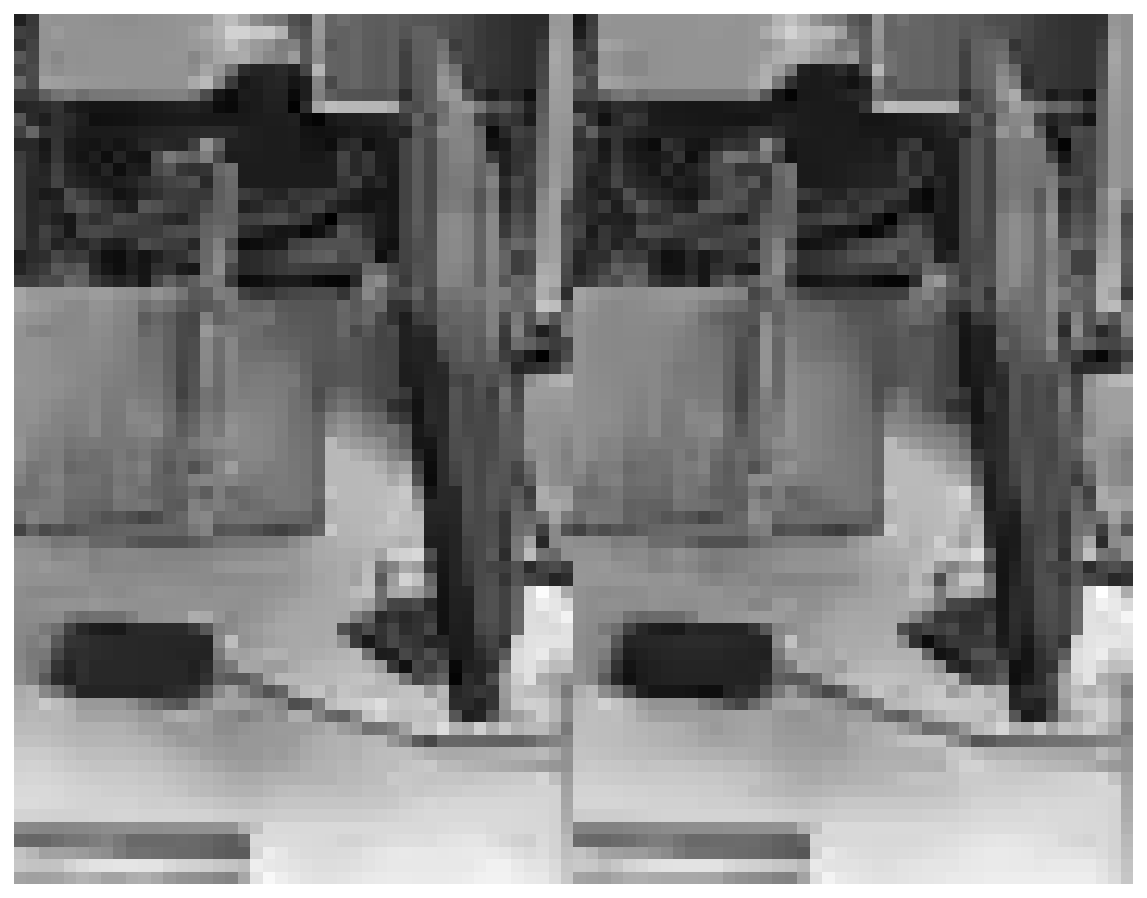

In [118]:
show_image(np.hstack([test1, test2]))

0


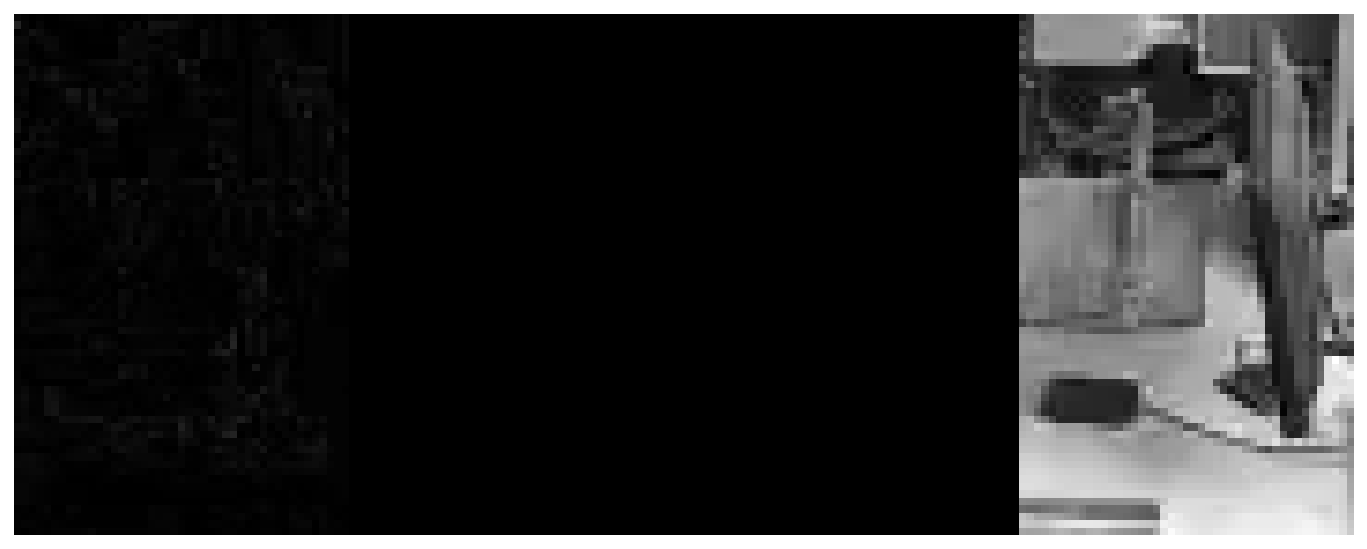

In [128]:
frame_tmp1 = cv2.absdiff(test1, test2)
frame_tmp2 = cv2.threshold(frame_tmp1, 100, 255, cv2.THRESH_BINARY)[1]
# frame_tmp4 = cv2.dilate(frame_tmp2, None, iterations=2)
frame_tmp3 = cv2.erode(frame_tmp2, None, iterations=1)
frame_tmp4 = cv2.dilate(frame_tmp3, None, iterations=2)
contours, _ = cv2.findContours(frame_tmp4, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))
for contour in contours:
    print(cv2.contourArea(contour))
test0 = test1.copy()
cv2.drawContours(test0, contours, -1, (255, 0, 255), 1)
# frame_tmp3,
show_image(np.hstack([frame_tmp1, frame_tmp2, frame_tmp4, test0]))

In [25]:
def show_image(imgsrc, width=None, height=None):
    if isinstance(imgsrc, np.ndarray):
        img = imgsrc
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if imgsrc.startswith('http'):
        data_url = imgsrc
    else:
        if len(imgsrc) > 2048:
            data_url = 'data:image/jpg;base64,' + imgsrc
        else:
            img = open(imgsrc, 'rb').read()
            data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<center><img %s %s src="%s"/></center>' % (W, H, data_url))


In [111]:
a = 10.0001

round(a - int(a), 6)

0.0001